# Import

In [1]:
from PIL import Image, ImageDraw, ImageOps
import cv2 

import os
from os import listdir
from os.path import isfile, join
import glob
from tqdm.notebook import tqdm
from IPython.display import clear_output

import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## trigonometry for vis stim size in pixels
visual_angle = 30
d_cm = 26.67 # distance from eye to monitor
w_cm = 53.34 # width of monitor
w_pix = 1920
h_cm = 29.972 # height of monitor, screen area only
h_pix = 1080

theta = visual_angle / 2 / 180 * np.pi # half of the visual angle, converted to radians
r_cm = d_cm * np.tan(theta) # radius of visual stim on screen
r_pix = r_cm * w_pix / w_cm
r_pix2 = r_cm * h_pix / h_cm
assert np.floor(r_pix) == np.floor(r_pix2) # two estimation should be close

stim_diameter = int(r_pix + r_pix2) # diameter of visual stim on screen, int takes care of np.floor
stim_diameter

514

# Construct Gaussian mask

(1.0, 1.0011098261124147)

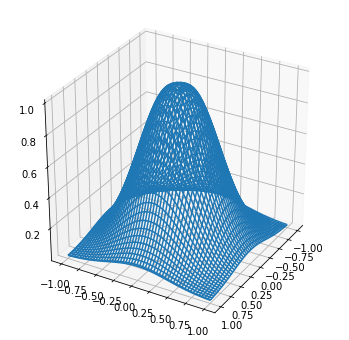

In [6]:
'''
https://mworks.tenderapp.com/discussions/questions/1296
https://mworks.tenderapp.com/discussions/problems/271-gaussian-mask-issue
https://mworks.tenderapp.com/discussions/questions/736#comment_43095821
https://mworks.github.io/documentation/0.8/components/drifting_grating_stimulus.html
https://mworks.tenderapp.com/search?utf8=%E2%9C%93&q=mask+std_dev+&t=d&recommend=1

Gaussian mask is computed on a 2x2 square, centered at the origin
dist is distance from the center
The mask is then stretched to cover a rectangle of x_size by y_size degrees. 
If the x and y sizes are equal, then the mask is scaled by size/2 in both directions, so std_dev has units of size/2 degrees

central region of the mask can have values greater than one 
(see https://mworks.tenderapp.com/discussions/problems/271-gaussian-mask-issue). 
However, the mask value is used as the output color's alpha, which is clamped to the range [0,1]. 
Hence, every pixel in the central region gets an alpha of 1.
'''

mask_mean = 0.1
mask_std = 0.3985 # try this to get rid of the center "black circle" -> ensure peak of gaussian is 1, not above 1 which creates black circle

u = np.linspace(-1, 1, stim_diameter, endpoint=True) # nstep = grating_diameter in terms of pixel number
[x, y] = np.meshgrid(u, u)
y = y[::-1] # ensure y axis points upwards

distance = np.sqrt(x**2 + y**2)
mask = np.exp(-1/2 * ((distance-mask_mean) / mask_std)**2) / (mask_std * np.sqrt(2*np.pi)) # default drifting grating has normalization term
mask_flat_peak = mask.copy()
mask_flat_peak[mask_flat_peak>1.0] = 1.0 # alpha value is capped at 1, creating flat peak

mask_0_base = (mask_flat_peak - max(mask_flat_peak[0,:]))
mask_0_base[mask_0_base<0] = 0 # force edge(outside of incircle)=0

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x,y,mask_flat_peak, rstride=10, cstride=10)
ax.view_init(elev=30, azim=30)
np.amax(mask_flat_peak), np.amax(mask)

# Construct grating

## gauss convolve with sinusoid

In [9]:
# http://vision.psych.umn.edu/users/kersten/kersten-lab/courses/Psy5036W2017/Lectures/17_PythonForVision/Demos/html/2b.Gabor.html

def myimshow(I, **kwargs):
    im_ratio = I.shape[0] / I.shape[1]
    plt.imshow(I, cmap='gray', **kwargs)
    plt.colorbar(fraction=0.046*im_ratio, pad=0.04)
    # plt.axis('off')


def genSinusoid(sz, A, omega, rho):
    # Generate Sinusoid grating
    # sz: size of generated image (width, height)
    # Generate sinusoid stimuli
    # Sinusoid  I(x)=Acos(ωx+ρ) 
    # A  is the amplitude,  ρ  is the phase, and  ω  is the frequency.
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]), range(-radius[1], radius[1]))
    stimuli = A * np.cos(omega[0] * x  + omega[1] * y + rho)
    return stimuli


def calc_freq_omega(freq_cycle_per_deg):
    # freq_cycle_per_deg: np array
    #   frequency of sinusoid grating in cycles per degree
    # return omega: np array
    #   frequency of sinusoid grating in radians per pixel
    freq_deg_per_cycle = 1.0 / freq_cycle_per_deg
    ncycle = visual_angle / freq_deg_per_cycle
    pix_per_cycle = stim_diameter / ncycle
    omega_x = 2*np.pi / pix_per_cycle # pixel per cycle = 2 * pi / omega
    return omega_x
assert math.isclose(calc_freq_omega(0.1), 0.03667228778509486, abs_tol = 0.001)

save_path = r'C:\Users\ll357\Documents\inter\results\interweaved vis stim - grating, nat img, noise'.replace('\\', '/')

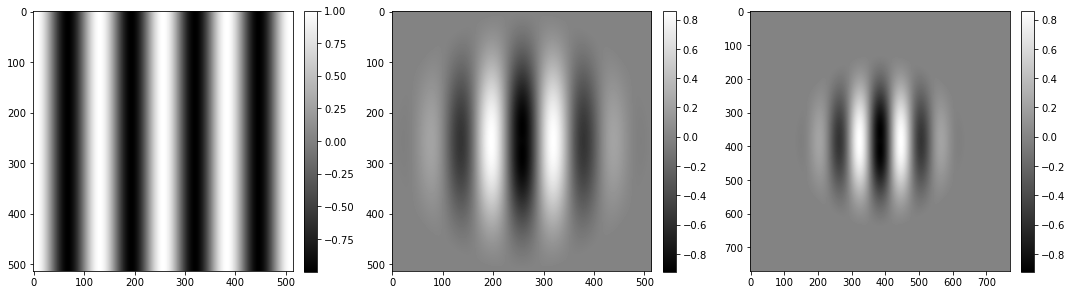

In [10]:
plt.figure(figsize=(15,6))

omega_x = 0.05
omega = [omega_x, 0.0]
rho = 0
sinusoidParam = {'A':1, 'omega':omega, 'rho':rho, 'sz':(stim_diameter, stim_diameter)}
sin = genSinusoid(**sinusoidParam)
plt.subplot(1,3,1)
myimshow(sin)

conv = mask_0_base * sin * -1 # convolve sin with gauss then invert
plt.subplot(1,3,2)
myimshow(conv)

conv_pad = np.pad(conv, ((128,128),(128,128)), 'constant', constant_values=(0)) # add padding to g
plt.subplot(1,3,3)
myimshow(conv_pad)

plt.tight_layout()

the middle subplot (RGBA) is the png in: https://drive.google.com/drive/folders/1TJoOnsZkR8KDe-NoPOEVE8m5J45hxODh?usp=sharing  
the left subplot (RGB) is the png in: https://drive.google.com/drive/folders/1Vg6Ctt2YUQq8fVCNUK5EcVHro2cYef3H?usp=sharing

## apply mask_0_base to sin as alpha channel

In [17]:
cpd_array = np.round(np.geomspace(0.03, 0.9, num=10), 2) # below 0.03 cpd, static grating is not visible
cpd_array = cpd_array[2:] # remove low freq
cpd_array = cpd_array[:-2] # remove high freq
cpd_str = ["{0:0.2f}".format(i) for i in cpd_array]
omega_list = calc_freq_omega(cpd_array)
os.chdir(save_path)

for omega_x, cpd_x in zip(omega_list, cpd_str):
    omega = [omega_x, 0.0]
    rho = 0
    sinusoidParam = {'A':1, 'omega':omega, 'rho':rho, 'sz':(stim_diameter, stim_diameter)}
    sin = genSinusoid(**sinusoidParam)

    no_mask_file_name = f"/grat_SF_{cpd_x}_no_mask.png"
    plt.imsave(fname=save_path + no_mask_file_name, arr=sin, cmap='gray_r', format='png') # RGB grating without alpha channel
    # save img with specific pixel number: https://stackoverflow.com/a/63091765
    # inverted grayscale "gray_r" takes care of the minus in (-1 * gauss * sinusoid)

    im_sin = Image.open(save_path + no_mask_file_name).convert('RGB')
    im_sin = np.array(im_sin)
    rgba = cv2.cvtColor(im_sin, cv2.COLOR_RGB2RGBA)

    mask_0_base = (mask_flat_peak - max(mask_flat_peak[0,:])) * 255 # convert mask from 0-1 to 0-255
    mask_0_base[mask_0_base<0] = 0 # force edge (outside of incircle) = 0
    mask_0_base = mask_0_base.astype(np.uint8)
    rgba[:, :, -1] = mask_0_base # assign mask to the last channel (alpha)
    img_rgba = Image.fromarray(rgba)
    img_rgba.save(save_path + f"/grat_alpha_{cpd_x}.png") # RGBA grating with alpha channel
    
    # display(img_rgba)